In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

2024-08-25 08:25:41.710129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 08:25:41.710242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 08:25:41.841048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Variables

In [2]:
height = 256
width = 256
image_size = (height,width)

batch_size = 16
lr = 0.0001
# epoch_size = 10
# epoch_size = 20
model_path_10 = '/kaggle/working/segmentation_model_10.keras'
model_path_20 = '/kaggle/working/segmentation_model_20.keras'

# Build U-Net

In [3]:
def conv_block(inputs, num_filters):
    """Convolutional Block with two convolutions, batch normalization, and ReLU activation."""
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    """Encoder Block with a convolutional block followed by max pooling."""
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder Block with transposed convolution, concatenation with skip features, and a convolutional block."""
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_unet(input_shape):
    """Builds the U-Net model by stacking encoder, bottleneck, and decoder blocks."""
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # bottleneck layer

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-NET")
    return model

In [5]:
input_shape = (256,256,3)
model1 = build_unet(input_shape)
model2 = build_unet(input_shape)
model1.summary()

Model: "U-NET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Evaluation Metrics

In [6]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# def iou(y_true, y_pred):
#     y_true = tf.keras.layers.Flatten()(y_true)
#     y_pred = tf.keras.layers.Flatten()(y_pred)
#     intersection = tf.reduce_sum(y_true * y_pred)
#     total = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     union = total - intersection
#     return (intersection + smooth) / (union + smooth)

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

# Load Dataset

In [8]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset('/kaggle/input/segmentation-data/aryas')

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

Train: 1092 - 1092
Valid: 364 - 364
Test : 364 - 364


# Data Augmentation & Preprocessing 

In [10]:
def augment(x, y):
    # Randomly flip the image and mask horizontally
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_left_right(x)
        y = tf.image.flip_left_right(y)

    # Randomly flip the image and mask vertically
    if tf.random.uniform(()) > 0.5:
        x = tf.image.flip_up_down(x)
        y = tf.image.flip_up_down(y)

    # Randomly rotate the image and mask
    angle = tf.random.uniform((), minval=-0.1, maxval=0.1)  # rotation angle in radians
    x = tf.image.rot90(x, k=int(angle / (np.pi / 2)))  # rotate by 90 degree multiples
    y = tf.image.rot90(y, k=int(angle / (np.pi / 2)))

    # Random zoom
    scale = tf.random.uniform((), minval=0.9, maxval=1.1)
    new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)

    x = tf.image.resize(x, (new_height, new_width))
    y = tf.image.resize(y, (new_height, new_width))

    x = tf.image.resize_with_crop_or_pad(x, height, width)
    y = tf.image.resize_with_crop_or_pad(y, height, width)

    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (width, height))  
    x = x / 255.0             
    x = x.astype(np.float32)    
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

def tf_dataset(X, Y, batch=2, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size, augment_data=True)
val_dataset = tf_dataset(valid_x, valid_y, batch=batch_size, augment_data=False)

# Callbacks

In [12]:
callbacks_10 = [
        ModelCheckpoint(model_path_10, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

callbacks_20 = [
        ModelCheckpoint(model_path_20, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

# Compile Model

In [13]:
model1.compile(loss=dice_loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy',dice_coef])
model2.compile(loss=dice_loss, optimizer=Adam(learning_rate=lr), metrics=['accuracy',dice_coef])

# Model Training

In [14]:
history_10 = model1.fit(train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=callbacks_10)

Epoch 1/10


2024-08-25 08:27:07.699373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-08-25 08:27:07.699620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-08-25 08:27:07.699747: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-08-25 08:27:07.699961: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-08-25 08:27:07.699976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-08-25 08:27:07.699984: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-08-25 08:27:07.699992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-08-25 08:27:07.700000: E ex

68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8770 - dice_coef: 0.2535 - loss: 0.7465

2024-08-25 08:28:35.547743: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.24577, expected 2.80959
2024-08-25 08:28:35.547803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.17396, expected 2.73778
2024-08-25 08:28:35.548261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.15611, expected 2.41005
2024-08-25 08:28:35.548287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 3.84262, expected 3.09657
2024-08-25 08:28:35.548303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.59187, expected 3.84581
2024-08-25 08:28:35.548319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 5.43123, expected 4.68518
2024-08-25 08:28:35.548331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65540: 5.1009, expected 4.35484
2024-08-25 08:28:35.548343: E exte

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8775 - dice_coef: 0.2548 - loss: 0.7453

2024-08-25 08:29:03.726327: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.59143, expected 2.72011
2024-08-25 08:29:03.726382: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.91216, expected 3.04084
2024-08-25 08:29:03.726392: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.94757, expected 4.07625
2024-08-25 08:29:03.726401: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.44113, expected 4.56981
2024-08-25 08:29:03.726409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.12543, expected 4.25411
2024-08-25 08:29:03.726417: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.68197, expected 4.81064
2024-08-25 08:29:03.726426: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.63124, expected 4.75992
2024-08-25 08:29:03.726434: E external/local_xla/xla/se


Epoch 1: val_loss improved from inf to 0.84867, saving model to /kaggle/working/segmentation_model_10.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8779 - dice_coef: 0.2560 - loss: 0.7441 - val_accuracy: 0.9562 - val_dice_coef: 0.1514 - val_loss: 0.8487 - learning_rate: 1.0000e-04
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9470 - dice_coef: 0.4766 - loss: 0.5234
Epoch 2: val_loss improved from 0.84867 to 0.83252, saving model to /kaggle/working/segmentation_model_10.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 442ms/step - accuracy: 0.9470 - dice_coef: 0.4769 - loss: 0.5231 - val_accuracy: 0.9582 - val_dice_coef: 0.1672 - val_loss: 0.8325 - learning_rate: 1.0000e-04
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9630 - dice_coef: 0.5770 - loss: 0.4230
Epoch 3: val_loss did not improve from 0.83252
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 411ms/step - accuracy: 0.9631 - dice_coef: 0.5773 - loss: 0.4227 - val_accuracy: 0.9521 - val_dice_coef: 0.0651

In [15]:
history_20 = model2.fit(train_dataset,
        epochs=20,
        validation_data=val_dataset,
        callbacks=callbacks_20)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7102 - dice_coef: 0.1914 - loss: 0.8087
Epoch 1: val_loss improved from inf to 0.88883, saving model to /kaggle/working/segmentation_model_20.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 60s 598ms/step - accuracy: 0.7117 - dice_coef: 0.1922 - loss: 0.8078 - val_accuracy: 0.2381 - val_dice_coef: 0.1114 - val_loss: 0.8888 - learning_rate: 1.0000e-04
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9370 - dice_coef: 0.3752 - loss: 0.6248
Epoch 2: val_loss improved from 0.88883 to 0.86634, saving model to /kaggle/working/segmentation_model_20.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 31s 441ms/step - accuracy: 0.9371 - dice_coef: 0.3755 - loss: 0.6245 - val_accuracy: 0.9584 - val_dice_coef: 0.1337 - val_loss: 0.8663 - learning_rate: 1.0000e-04
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9563 - dice_coef: 0.4540 - loss: 0.5460
Epoch 3: val_loss improved from 0.86634 to 0.82013, saving model to /kaggle/workin

# Plot Learning Curves

In [16]:
def plot_curve(history):
    # Extract data from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    dice_coef = history.history['dice_coef']
    val_dice_coef = history.history['val_dice_coef']
    
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dice_coef, 'bo', label='Training Dice Coefficient')
    plt.plot(epochs, val_dice_coef, 'b', label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

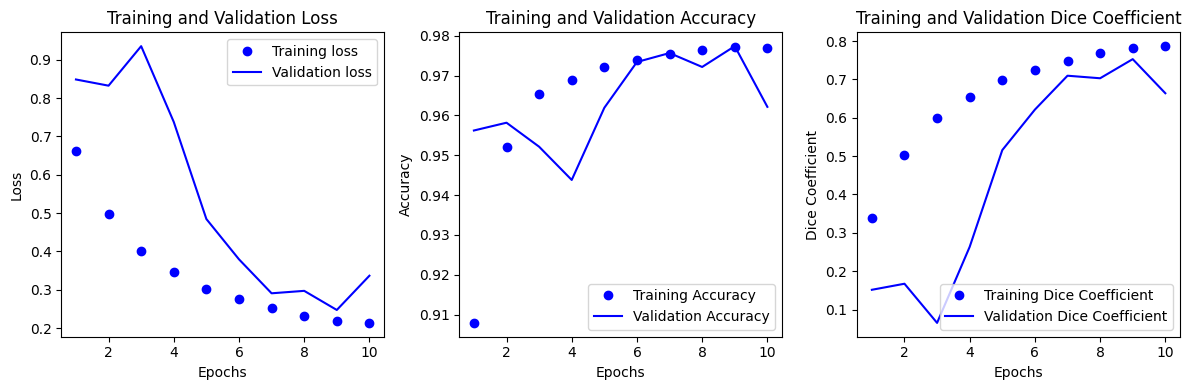

In [17]:
plot_curve(history_10)

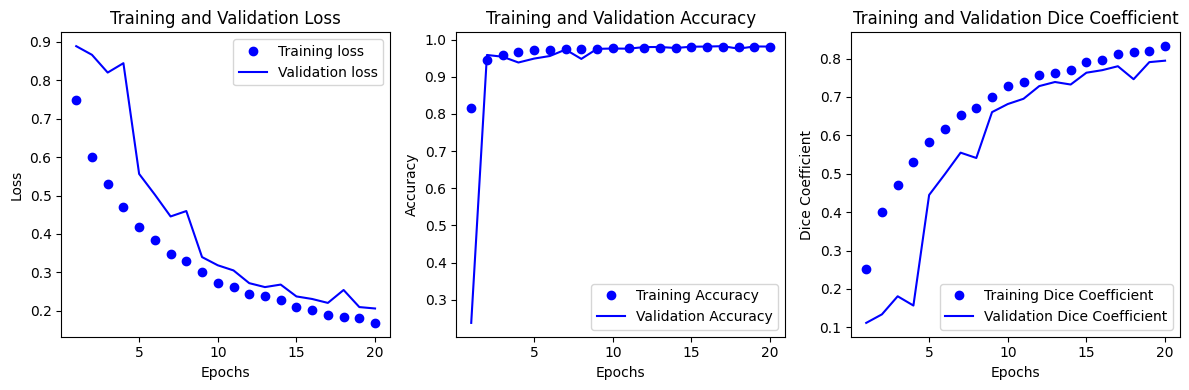

In [18]:
plot_curve(history_20)

# Evaluate on test set

In [19]:
test_dataset = tf_dataset(test_x, test_y, batch=batch_size, augment_data=False)

In [20]:
model1.evaluate(test_dataset)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9626 - dice_coef: 0.6740 - loss: 0.3259


[0.3226907551288605, 0.9630743265151978, 0.6765698194503784]

In [21]:
model2.evaluate(test_dataset)

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9814 - dice_coef: 0.8015 - loss: 0.1985


[0.19382426142692566, 0.9816226959228516, 0.8057518601417542]

In [22]:
# Function to preprocess the image
def preprocess_image(image_path, width, height):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (width, height))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Function to preprocess the mask
def preprocess_mask(mask_path, width, height):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (width, height))
    mask = mask / 255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    return mask

# Function to predict the mask using the model
def predict_mask(model, image):
    y_pred = model.predict(image, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32).flatten()
    return y_pred

# Function to calculate evaluation metrics
def calculate_metrics(mask, y_pred):
    accuracy_value = accuracy_score(mask, y_pred)
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    return accuracy_value, f1_value, recall_value, precision_value

# Function to evaluate a model on a dataset
def evaluate_model(model, test_x, test_y, width, height):
    scores = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        # Extract name
        name = os.path.basename(x)

        # Preprocess image and mask
        image = preprocess_image(x, width, height)
        mask = preprocess_mask(y, width, height)

        # Predict mask
        y_pred = predict_mask(model, image)

        # Calculate metrics
        accuracy_value, f1_value, recall_value, precision_value = calculate_metrics(mask, y_pred)

        # Append results
        scores.append([name, accuracy_value, f1_value, recall_value, precision_value])

    return scores

# Main function to evaluate multiple models
def evaluate_models(models, test_x, test_y, width, height):
    results = {}
    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")
        results[model_name] = evaluate_model(model, test_x, test_y, width, height)
    return results

In [23]:
# Example usage
models = {
    'Model_1_10_epoch': model1,
    'Model_2_20_epoch': model2
}

results = evaluate_models(models, test_x, test_y, width=256, height=256)

Evaluating model: Model_1_10_epoch


  0%|          | 0/364 [00:00<?, ?it/s]2024-08-25 08:56:28.445748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-08-25 08:56:28.445817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-08-25 08:56:28.445827: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-08-25 08:56:28.445835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-08-25 08:56:28.445843: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-08-25 08:56:28.445852: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-08-25 08:56:28.445860: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-08-25 08:56:28

Evaluating model: Model_2_20_epoch


100%|██████████| 364/364 [01:00<00:00,  6.03it/s]


In [24]:
# Printing the results for each model
for model_name, scores in results.items():
    print(f"Results for {model_name}:")
    print(f"{'Image Name':<20} {'Accuracy':<10} {'F1 Score':<10} {'Recall':<10} {'Precision':<10}")
    print("-" * 60)
    for score in scores:
        name, accuracy, f1, recall, precision = score
        print(f"{name:<20} {accuracy:<10.4f} {f1:<10.4f} {recall:<10.4f} {precision:<10.4f}")
    print("\n")

Results for Model_1_10_epoch:
Image Name           Accuracy   F1 Score   Recall     Precision 
------------------------------------------------------------
fy68.png             0.9929     0.7929     0.9492     0.6809    
y734.png             0.9249     0.2380     0.4256     0.1652    
y730.png             0.8658     0.5828     0.6097     0.5582    
fy606.png            0.9762     0.4706     0.8182     0.3303    
fy516.png            0.9801     0.8661     0.9277     0.8122    
55.png               0.9432     0.2673     1.0000     0.1543    
fy692.png            0.9809     0.8707     0.9658     0.7926    
fy262.png            0.9697     0.9222     0.9726     0.8767    
y282.png             0.9767     0.6785     0.9957     0.5146    
fy728.png            0.9904     0.8663     0.7806     0.9732    
fy102.png            0.9901     0.8855     0.9863     0.8034    
y119.png             0.9389     0.1996     0.9765     0.1112    
135.png              0.9900     0.9072     0.9307     0.8848    

In [25]:
# Calculating average metrics for each model
for model_name, scores in results.items():
    avg_accuracy = np.mean([score[1] for score in scores])
    avg_f1 = np.mean([score[2] for score in scores])
    avg_recall = np.mean([score[3] for score in scores])
    avg_precision = np.mean([score[4] for score in scores])

    print(f"Average results for {model_name}:")
    print(f"Accuracy: {avg_accuracy:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print("\n")

Average results for Model_1_10_epoch:
Accuracy: 0.9661
F1 Score: 0.6755
Recall: 0.8884
Precision: 0.5873


Average results for Model_2_20_epoch:
Accuracy: 0.9847
F1 Score: 0.8152
Recall: 0.9062
Precision: 0.7853




In [26]:
import pandas as pd

# Convert the results to a pandas DataFrame and save to CSV
for model_name, scores in results.items():
    df = pd.DataFrame(scores, columns=['Image Name', 'Accuracy', 'F1 Score', 'Recall', 'Precision'])
    csv_filename = f"{model_name}_results.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results for {model_name} saved to {csv_filename}")

Results for Model_1_10_epoch saved to Model_1_10_epoch_results.csv
Results for Model_2_20_epoch saved to Model_2_20_epoch_results.csv


# Save model

In [27]:
save_model(model1,'segmentation_10.h5')
save_model(model2,'segmentation_20.h5')

# Test best model(pipeline)

In [28]:
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model('/kaggle/working/segmentation_20.h5')

In [29]:
# Function to preprocess and predict on a new image
def predict_and_overlay(image_path, model):
    # Read the new image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = image.copy()  # Keep a copy for visualization later

    # Preprocess the image (resize, normalize)
    resized_image = cv2.resize(image, (256, 256))  # Adjust as per your model's input size
    preprocessed_image = resized_image.astype(np.float32) / 255.0  # Normalize to [0, 1]

    # Make prediction
    input_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension
    predicted_mask = model.predict(input_image)[0]  # Assuming model output is the predicted mask

    # Post-process the predicted mask (thresholding, resizing if necessary)
    thresholded_mask = (predicted_mask >= 0.5).astype(np.uint8)  # Example thresholding

    # Resize the mask to match original image dimensions
    resized_mask = cv2.resize(thresholded_mask, (original_image.shape[1], original_image.shape[0]))

    # Create overlay by highlighting tumor regions on the original image
    overlay = original_image.copy()
    overlay[resized_mask == 1] = (0, 0, 255)  # Highlight tumor regions in red
    
    # Add transparency (alpha blending)
    alpha = 0.5
    blended = cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0)

    # Display the overlayed image using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title('Tumour Detected')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


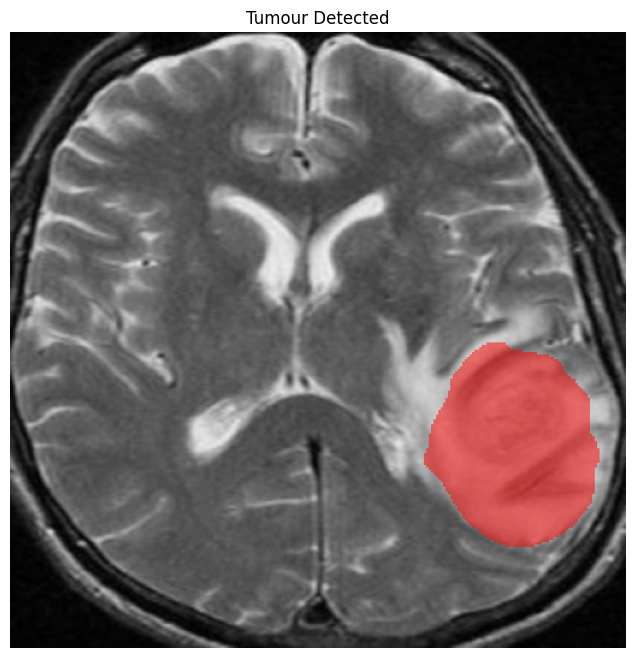

In [30]:
image_path = '/kaggle/input/segmentation-data/aryas/images/65.png'
predict_and_overlay(image_path, model)